<a href="https://colab.research.google.com/github/crux82/BISS-2024/blob/main/BISS-2024_LAB-1_Training_BERT_based_models_in_few_lines_of_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BISS 2024**

# ACTI A sentence classifier using a BERT-based model

**Based on**: https://github.com/crux82/BISS-2024/blob/main/BISS-2024_LAB-1_Training_BERT_based_models_in_few_lines_of_code.ipynb

Given an input sentence, we will:
1. Use a BERT-based architecture to encode it
2. Use a linear binary classifier to associate the produced vector to one of the 2 classes considered in the task (Sì / No)

## **Step 0**: Python Imports

In [1]:
!pip install transformers==4.37.2

import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

# Set random values
seed_val = 213
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

Check if a GPU is available for training the architecture. We can also use CPUs but it is "quite" slow.

In [2]:
# Tell PyTorch to use the GPU, if available
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("There are %d GPU(s) available." % torch.cuda.device_count())
  print("We will use the GPU:", torch.cuda.get_device_name(0))
# Use the Mac's MPS, if available
elif torch.backends.mps.is_available():
  device = torch.device("mps")
  print("Using the MPS device for Mac")
# Use the GPU otherwise
else:
  print("No GPU available, using the CPU instead.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## **Step 1**: Load dataset

### **Task**: ACTI A - Conspiratorial Content Classification

https://www.kaggle.com/competitions/acti-subtask-a

A system must recognize if a telegram post is conspiratorial or not.

- A sentence is *Conspiratorial* if either (i) expresses the belief that major events(e.g., covid) are manipulation created by powerful people to protect their interests or (ii) an interpretation of events meant to contribute to strengthening the underlying narrative of the conspiracy theory.
- A sentence is *Not Conspiratorial* if it does not diffuse any kind of beliefs linked to the conspiracy theory.

Define the method to load the dataset:

In [3]:
import csv

def load_acti_a(input_file):
  """Creates examples for the training and dev sets."""
  examples = []
  labels = []

  with open(input_file, "r") as infile:
    reader = csv.reader(infile)
    next(reader, None) # Skip the headers
    for row in reader:
      text = row[1]
      label = row[2]
      labels.append(label)
      examples.append((text, label))

  return examples, set(labels)

Load data:

In [4]:
# Retrieve the dataset
! wget -nc https://raw.githubusercontent.com/nicolasfara/biss-llm-final-exam/master/data/acti-a/subtaskA_train.csv
! wget -nc https://raw.githubusercontent.com/nicolasfara/biss-llm-final-exam/master/data/acti-a/subtaskA_test.csv

dataset_filename = "subtaskA_train.csv"
testset_filename = "subtaskA_test.csv"

# Load the data
dataset, labels = load_acti_a(dataset_filename)

train_examples, test_examples = np.split(dataset, [int(len(dataset)*0.8)])
train_labels = labels
test_labels = labels

# TODO: try K-fold cross-validation?

File ‘subtaskA_train.csv’ already there; not retrieving.

File ‘subtaskA_test.csv’ already there; not retrieving.



Print some examples

In [5]:
print("Some training examples:\n")

for i in range(1, 10):
  print(train_examples[i])

Some training examples:

['21/08/21]( [PRE-PRINT]\n\n📄__ "Shedding of Infectious SARS-CoV-2 Despite Vaccination"\n🇮🇹 "Diffusione del SARS-CoV-2 nonostante la vaccinazione"__\n\n📊 "La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale. [...] le indagini sull\'epidemia suggeriscono che le persone vaccinate possono diffondere [la variante] Delta"\n\n⚠️ "[...] questi risultati indicano che anche le **persone asintomatiche e comple vaccinate possono diffondere il virus infettivo**."\n\n⚠️ "[...] questi dati indicano che gli individui **vaccinati e non vaccinati** infettati dalla variante Delta **possono trasmettere l\'infezione**."\n\n📚 **'
 '1']
['PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA\'\nLa scorsa settimana Elon Musk ha dichiarato di volere che la "libertà di parola" sui social media sia tutelata ai sensi della Legge del Paese.\nI DEM sono spaventatissimi dalla scelta coraggi

Process the target classes to generate a dictionary. It will be used also to specify the number of classes used in the classification task. This is a binary classification task so we will always get 2 classes.

In [6]:
label_list = list(train_labels.union(test_labels))
label_list.sort()

# Let us print the labels used in the dataset
print("Target Labels:\t" + str(label_list))
print("Number of Labels:\t" + str(len(label_list)))

Target Labels:	['0', '1']
Number of Labels:	2


### **Step 1.5**: Data preprocessing

In [ ]:
# TODO see data-preprocess/acti.py

##  **Step 2:** Select an Encoder

Uncomment a model name to use it for building the final architecture.
Each architecture is characterized by a different number of layers and parameters, and pre-trained on different document collections.

Since our data is in Italian, we have selected the following models:
- Alberto: https://journals.openedition.org/ijcol/472
- UmBERTo: https://github.com/musixmatchresearch/umberto

**TODO**: should we try more models from https://huggingface.co/models?

In [7]:
alberto_model = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
umberto_model = "Musixmatch/umberto-commoncrawl-cased-v1"

model_name = alberto_model

## **Step 3:** Define the Pytorch classifier

In PyTorch, a neural nettowrk extends a `nn.Module` where:
- the ``__init__`` method is used to initialize the different blocks of the netowek (here the BERT-based encoder and the final classifier).
- the ``forward`` method is invoked by the training procedure for each batch of data and convert input data (here sentences) to the outcome of the classification (here if forms of "logits").

**Notice**: in order to make our classifier independent from the adopted encoder, we use `Automodel` methods: https://huggingface.co/transformers/v4.3.3/model_doc/auto.html

This code, in fact, shows a sort of different use of the Huggingface classes, where the `transformers.BertForSequenceClassification` is generally used. Unfortunately `BertForSequenceClassification` is not compatible with all models, such as the ones based on `RoBERTa`.

In [8]:
class Classifier(nn.Module):
  def __init__(self, model_name, num_labels=2, dropout_rate=0.1):
    super(Classifier, self).__init__()
    # Load the BERT-based encoder
    self.encoder = AutoModel.from_pretrained(model_name)
    # The AutoConfig allows to access the encoder configuration.
    # The configuration is needed to derive the size of the embedding, which
    # is produced by BERT (and similar models) to encode the input elements.
    config = AutoConfig.from_pretrained(model_name)
    self.cls_size = int(config.hidden_size)
    # Dropout is applied before the final classifier to prevent overfitting
    self.input_dropout = nn.Dropout(p=dropout_rate)
    # Final linear classifier
    self.fully_connected_layer = nn.Linear(self.cls_size,num_labels)

  def forward(self, input_ids, attention_mask):
    # Encode all outputs
    model_outputs = self.encoder(input_ids, attention_mask, output_hidden_states=True)
    # Just select the vector associated to the [CLS] symbol used as
    # first token for ALL sentences
    last_hidden_states = model_outputs.hidden_states[-1]
    # The shape of last_hidden_states will be [batch_size, tokens, hidden_dim] so
    # if you want to get the embedding of the first element in the batch
    # and the [CLS] token you can get it with last_hidden_states[0,0,:].
    encoded_cls = last_hidden_states[:,0,:]
    # Apply dropout
    encoded_cls_dp = self.input_dropout(encoded_cls)
    # Apply the linear classifier
    logits = self.fully_connected_layer(encoded_cls_dp)
    # Return the logits
    return logits, encoded_cls

## **Step 4:** Customize input parameters



In order to customize one parameter (i.e. the maximum size of input sequences) we need to process the datasets.

**IMPORTANT** input sequences are expected to be tokenized in order to be used in input to a BERT-based model. This requires a `tokenizer` which converts each input sentence into a sequence of word-pieces, each asociated to input vectors, which can be used as input in the encoder. Each model is associated to a `tokenizer` which is acquired before the initial training process.

More info about tokenizers: https://huggingface.co/transformers/preprocessing.html

A BERT-based model imposes a maximum value to the size of input sequences (actually a sequence of word pieces). For example, BERT can encode sentences up to 512 word pieces. If the input sentences are shorter, it is a good idea to reduce the maximum length of the input text, also to reduce the memory used to store the model (e.g., in a GPU).

More details about possible memory issues can be found here: https://github.com/google-research/bert#out-of-memory-issues

The following code plots the length of the input (train) sentences.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--m-polignano-un

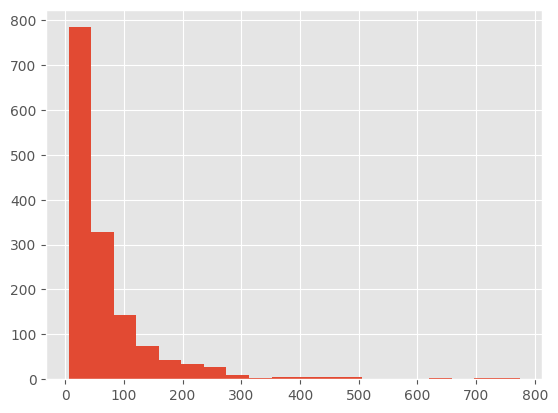

In [9]:
# Define a Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Print the length distribution
plt.style.use("ggplot")
plt.hist([len(tokenizer.encode_plus(text)["input_ids"]) for text, label in train_examples], bins=20)
plt.show()

Define encoder parameters:

In [27]:
# Maximum length to be considered in input
max_seq_length = 128
# TODO: BERT can't handle more than 512 tokens, but we have up to around 800+...

# Dropout applied to the embedding produced by BERT before the classifiation
out_dropout_rate = 0.1

Define training parameters:

In [28]:
# Dev percentage split, i.e., the percentage of training material to be use for
# evaluating the model during training
dev_perc = 0.1

# Batch size
batch_size = 64

# Learning rate used during the training process
learning_rate = 2e-5
# If you use large models (such as Bert-large) it is a good idea to use
# smaller values, such as 5e-6

# Name of the fine_tuned_model
output_model_name = "best_model.pickle"

# Number of training epochs
num_train_epochs = 5
# Below in the original document it was suggested to stay between 20 and 50 epochs,
# so we should probably change this value?

# TODO: should we mess with schedulers?

# ADVANCED: Schedulers allow to define dynamic learning rates.
# You can find all available schedulers here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html
apply_scheduler = False
# Here a `Constant schedule with warmup`can be activated. More details here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_constant_schedule_with_warmup
warmup_proportion = 0.1

Define log parameters:

In [29]:
# Print a log each n steps
print_each_n_step = 10

## **Step 5**: Convert data into Dataloader(s)

The following method is used to convert input material into `DataLoader` that will be used to handle examples (during the training and the evaluation phase). Dataloaders are used in PyTorch to handle data, to split it into batches and to shuffle data: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

First, define a function to implement such conversion:

In [30]:
def generate_data_loader(examples, label_map, tokenizer, do_shuffle = False):
  """
  Generate a Dataloader given the input examples.

  `examples`: a list of pairs (input_text, label)
  `label_mal`: a dictionary used to assign an ID to each label
  `tokenize`: the tokenizer used to convert input sentences into word pieces
  `do_shuffle`: a boolean parameter to shuffle input examples (usefull in training)
  """

  # Generate input examples to the Transformer
  input_ids = []
  input_mask_array = []
  label_id_array = []

  # Tokenization
  for (text, label) in examples:
    # tokenizer.encode_plus is a crucial method which:
    # 1. Tokenizes examples
    # 2. Trims sequences to a max_seq_length
    # 3. Applies a pad to shorter sequences
    # 4. Assigns the [CLS] special word-piece such as the other ones (e.g., [SEP])
    encoded_sent = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    # Convert input word pieces to IDs of the corresponding input embeddings
    input_ids.append(encoded_sent["input_ids"])
    # Store the attention mask to avoid computations over "padded" elements
    input_mask_array.append(encoded_sent["attention_mask"])

    # Converts labels to IDs
    id = -1
    if label in label_map:
      id = label_map[label]
    label_id_array.append(id)

  # Convert to Tensor which are used in PyTorch
  input_ids = torch.tensor(input_ids)
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array)

  if do_shuffle:
    # This will shuffle examples each time a new batch is required
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
    dataset,  # The training samples
    sampler = sampler(dataset), # the adopted sampler
    batch_size = batch_size # Train with this batch size
  )


Then, apply it.


In [31]:
# Initialize a map to associate labels to the dimension of the embedding
# produced by the classifier
label_to_id_map = {}
id_to_label_map = {}
for (i, label) in enumerate(label_list):
  label_to_id_map[label] = i
  id_to_label_map[i] = label

# Shuffle and split the training material in train/dev
random.shuffle(train_examples)
train_subset_examples = train_examples[int(len(train_examples) * 0) : int(len(train_examples) * (1-dev_perc))]
dev_subset_examples = train_examples[int(len(train_examples) * (1-dev_perc)) : int(len(train_examples))]

# Build the Train DataLoader
train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Development DataLoader
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Test DataLoader
test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, do_shuffle = False)

print("Number of training examples:\t"+ str(len(train_subset_examples)))
print("Number of development examples:\t"+ str(len(dev_subset_examples)))
print("Number of test examples:\t"+ str(len(test_examples)))


Number of training examples:	1325
Number of development examples:	148
Number of test examples:	369


## **Step 6**: Train the model

Before training the model, define the evaluation method which will be applied to development and test datasets:

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def evaluate(dataloader, classifier, print_classification_output=False, print_result_summary=False):
  """
  Evaluation method which will be applied to development and test datasets.
  It returns the pair (average loss, accuracy)

  dataloader: a dataloader containing examples to be classified
  classifier: the BERT-based classifier
  print_classification_output: to log the classification outcomes
  """
  total_loss = 0
  gold_classes = []
  system_classes = []

  if print_classification_output:
    print("\n------------------------")
    print("  Classification outcomes")
    print("is_correct\tgold_label\tsystem_label\ttext")
    print("------------------------")

  # For each batch of examples from the input dataloader
  for batch in dataloader:
    # Unpack this training batch from our dataloader. Notice this is populated
    # in the method `generate_data_loader`
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      # Each batch is classifed
      logits, _ = classifier(b_input_ids, b_input_mask)
      # Evaluate the loss.
      total_loss += nll_loss(logits, b_labels)

    # Accumulate the predictions and the input labels
    _, preds = torch.max(logits, 1)
    system_classes += preds.detach().cpu()
    gold_classes += b_labels.detach().cpu()

    # Print the output of the classification for each input element
    if print_classification_output:
      for ex_id in range(len(b_input_mask)):
        input_strings = tokenizer.decode(b_input_ids[ex_id], skip_special_tokens=True)
        # convert class id to the real label
        predicted_label = id_to_label_map[preds[ex_id].item()]
        gold_standard_label = "UNKNOWN"
        # convert the gold standard class ID into a real label
        if b_labels[ex_id].item() in id_to_label_map:
          gold_standard_label = id_to_label_map[b_labels[ex_id].item()]
        # put the prefix "[OK]" if the classification is correct
        output = "[OK]" if predicted_label == gold_standard_label else "[NO]"
        # print the output
        print(output+"\t"+gold_standard_label+"\t"+predicted_label+"\t"+input_strings)

  # Calculate the average loss over all of the batches.
  avg_loss = total_loss / len(dataloader)
  avg_loss = avg_loss.item()

  # Report the final accuracy for this validation run.
  system_classes = torch.stack(system_classes).numpy()
  gold_classes = torch.stack(gold_classes).numpy()
  accuracy = np.sum(system_classes == gold_classes) / len(system_classes)

  if print_result_summary:
    print("\n------------------------")
    print("  Summary")
    print("------------------------")
    #remove unused classes in the test material
    filtered_label_list = []
    for i in range(len(label_list)):
      if i in gold_classes:
        filtered_label_list.append(id_to_label_map[i])
    print(classification_report(gold_classes, system_classes, digits=3, target_names=filtered_label_list))

    print("\n------------------------")
    print("  Confusion Matrix")
    print("------------------------")
    conf_mat = confusion_matrix(gold_classes, system_classes)
    for row_id in range(len(conf_mat)):
      print(filtered_label_list[row_id]+"\t"+str(conf_mat[row_id]))

  return avg_loss, accuracy

Instantiate the classifier and initialize the Optimizer:

In [33]:
classifier = Classifier(model_name, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put the model in the device (GPU or MPS or CPU)
classifier.to(device)

# Define the Optimizer. Here the ADAM optimizer (a sort of standard de-facto) is
# used. AdamW is a variant which also adopts Weigth Decay.
optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate)
# More details about the Optimizers can be found here:
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html

# Define the scheduler
if apply_scheduler:
  # Estimate the numbers of step corresponding to the warmup.
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)
  # Initialize the scheduler
  scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--m-polignano-uniba--bert_uncased_L-12_H-768_A-12_italian_alb3rt0/snapshots/4454cfbc82952da79729e33e81c37a72dc095b4b/config.json
Model config BertConfig {
  "_name_or_path": "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "

This method is used for pretty prints. It takes a time in seconds and returns a string hh:mm:ss

In [17]:
def format_time(elapsed):
  """
  Takes a time in seconds and returns a string hh:mm:ss
  """
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))
  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

Training steps:
1. Clear the gradients of all optimized variables
1. Forward pass: compute predicted outputs by passing inputs to the model
2. Calculate the loss
3. Backward pass: compute gradient of the loss with respect to model parameters
4. Perform a single optimization step (parameter update)
5. Update average training loss

**NOTE**: at the end of each epoch the model is evaluated over the development set and it is saved only if the performance is improved.

In [34]:
training_stats = []

# Define the LOSS function. A CrossEntropyLoss is used for multi-class
# classification tasks.
# TODO: is this loss fn fine for binary classification?
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)
# All loss functions are available at https://pytorch.org/docs/stable/nn.html#loss-functions

# Measure the total training time for the whole run
total_t0 = time.time()

# NOTE: the measure to be maximized should depends on the task
# Here accuracy is used
best_dev_accuracy = -1

for epoch_i in range(0, num_train_epochs):
  # --------
  # Training
  # --------

  # Perform one full pass over the training set
  print("")
  print("======== Epoch {:} / {:} ========".format(epoch_i + 1, num_train_epochs))
  print("Training...")

  # Measure how long the training epoch takes
  t0 = time.time()
  # Reset the total loss for this epoch
  train_loss = 0
  # Put the model into training mode
  classifier.train()

  for step, batch in enumerate(train_dataloader):
    # Progress update every print_each_n_step batches
    if step % print_each_n_step == 0 and not step == 0:
      # Calculate elapsed time in minutes
      elapsed = format_time(time.time() - t0)
      # Report progress
      print("  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(step, len(train_dataloader), elapsed))

    # Unpack this training batch from our dataloader
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    train_logits, _ = classifier(b_input_ids, b_input_mask)
    # calculate the loss
    loss = nll_loss(train_logits, b_labels)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update running training loss
    train_loss += loss.item()

    # Update the learning rate with the scheduler, if specified
    if apply_scheduler:
      scheduler.step()

  # Calculate the average loss over all of the batches
  avg_train_loss = train_loss / len(train_dataloader)

  # Measure how long this epoch took
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.3f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  # ---------------------------------
  # Evaluation on the Development set
  # ---------------------------------

  print("")
  print("Running Test...")

  t0 = time.time()

  # Put the model in evaluation mode (dropout layers behave differently during evaluation)
  classifier.eval()

  # Apply the evaluate_method defined above to estimate
  avg_dev_loss, dev_accuracy = evaluate(test_dataloader, classifier)

  # Measure how long the validation run took
  test_time = format_time(time.time() - t0)

  print("  Accuracy: {0:.3f}".format(dev_accuracy))
  print("  Test Loss: {0:.3f}".format(avg_dev_loss))
  print("  Test took: {:}".format(test_time))

  # Record all statistics from this epoch
  training_stats.append(
    {
      "epoch": epoch_i + 1,
      "Training Loss": avg_train_loss,
      "Valid. Loss": avg_dev_loss,
      "Valid. Accur.": dev_accuracy,
      "Training Time": training_time,
      "Test Time": test_time
    }
  )

  # Save the model if the performance on the development set increases
  if dev_accuracy > best_dev_accuracy:
    best_dev_accuracy = dev_accuracy
    torch.save(classifier, output_model_name)
    print("\n  Saving the model during epoch " + str(epoch_i))
    print("  Actual Best Validation Accuracy: {0:.3f}".format(best_dev_accuracy))



======== Epoch 1 / 5 ========
Training...
  Batch    10  of     21.    Elapsed: 0:00:12.
  Batch    20  of     21.    Elapsed: 0:00:24.

  Average training loss: 0.395
  Training epcoh took: 0:00:25

Running Test...
  Accuracy: 0.707
  Test Loss: 0.613
  Test took: 0:00:03

  Saving the model during epoch 0
  Actual Best Validation Accuracy: 0.707

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     21.    Elapsed: 0:00:12.
  Batch    20  of     21.    Elapsed: 0:00:24.

  Average training loss: 0.088
  Training epcoh took: 0:00:25

Running Test...
  Accuracy: 0.737
  Test Loss: 0.704
  Test took: 0:00:03

  Saving the model during epoch 1
  Actual Best Validation Accuracy: 0.737

======== Epoch 3 / 5 ========
Training...
  Batch    10  of     21.    Elapsed: 0:00:13.
  Batch    20  of     21.    Elapsed: 0:00:25.

  Average training loss: 0.014
  Training epcoh took: 0:00:26

Running Test...
  Accuracy: 0.721
  Test Loss: 0.853
  Test took: 0:00:03

======== Epoch 4 / 5 =

Print some statistics about the training

{'epoch': 1, 'Training Loss': 0.39532905107452754, 'Valid. Loss': 0.6133481860160828, 'Valid. Accur.': 0.7073170731707317, 'Training Time': '0:00:25', 'Test Time': '0:00:03'}
{'epoch': 2, 'Training Loss': 0.08757555147721655, 'Valid. Loss': 0.703586995601654, 'Valid. Accur.': 0.7371273712737128, 'Training Time': '0:00:25', 'Test Time': '0:00:03'}
{'epoch': 3, 'Training Loss': 0.01357159775770491, 'Valid. Loss': 0.8525730967521667, 'Valid. Accur.': 0.7208672086720868, 'Training Time': '0:00:26', 'Test Time': '0:00:03'}
{'epoch': 4, 'Training Loss': 0.002689865639521962, 'Valid. Loss': 1.0013673305511475, 'Valid. Accur.': 0.7127371273712737, 'Training Time': '0:00:26', 'Test Time': '0:00:03'}
{'epoch': 5, 'Training Loss': 0.0007140419509683159, 'Valid. Loss': 1.1269681453704834, 'Valid. Accur.': 0.7181571815718157, 'Training Time': '0:00:27', 'Test Time': '0:00:03'}


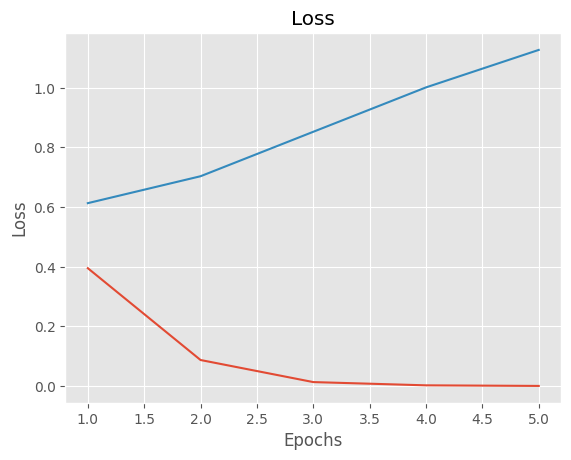

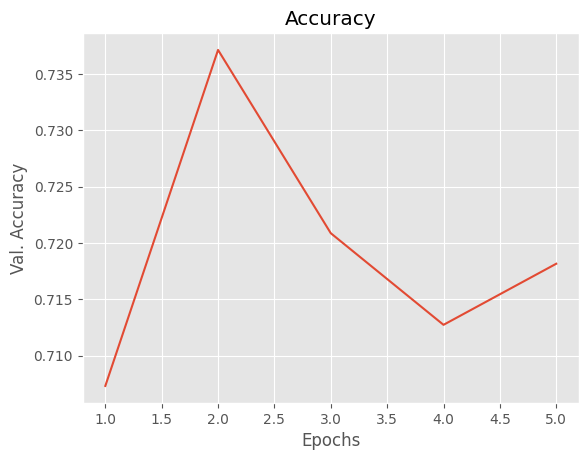


Training complete!
Total training took 0:03:11 (h:mm:ss)


In [35]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for stat in training_stats:
  train_losses.append(stat["Training Loss"])
  val_losses.append(stat["Valid. Loss"])
  val_acc.append(stat["Valid. Accur."])
  print(stat)

plt.plot(range(1,num_train_epochs+1), train_losses, label = "Training Loss")
plt.plot(range(1,num_train_epochs+1), val_losses, label = "Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(range(1,num_train_epochs+1), val_acc, label = "Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Val. Accuracy")
plt.show()

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## **Step 7**: Evaluate the model

We can evaluate the model maximizing the performance over the development set (saved on file).

In [ ]:
# Load the best model
best_model = torch.load(output_model_name)

# Evaluate it
avg_test_loss, test_accuracy = evaluate(
  test_dataloader,
  best_model,
  print_classification_output = True,
  print_result_summary=True
)

print("\n\n  Accuracy: {0:.3f}".format(test_accuracy))
print("  Test Loss: {0:.3f}".format(avg_test_loss))


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[OK]	NUM	NUM	How far is it from Denver to Aspen?
[OK]	LOC	LOC	What county is Modesto, California in?
[OK]	HUM	HUM	Who was Galileo?
[OK]	DESC	DESC	What is an atom?
[OK]	NUM	NUM	When did Hawaii become a state?
[OK]	NUM	NUM	How tall is the Sears Building?
[OK]	HUM	HUM	George Bush purchased a small interest in which baseball team?
[OK]	ENTY	ENTY	What is Australia's national flower?
[OK]	DESC	DESC	Why does the moon turn orange?
[OK]	DESC	DESC	What is autism?
[OK]	LOC	LOC	What city had a world fair in 1900?
[OK]	HUM	HUM	What person's head is on a dime?
[OK]	NUM	NUM	What is the average weight of a Yellow Labrador?
[OK]	HUM	HUM	Who was the first man to fly across the Pacific Ocean?
[OK]	NUM	NUM	When did Idaho become a state?
[OK]	NUM	NUM	What is the life expectancy for crickets?
[OK]	ENTY	ENTY	What metal has the highest melting point?
[OK]	HUM	HUM	Who developed the vaccination a

### **Step 7.1**: Use the model on some new data

We can apply the best model even to new examples not belonging to any dataset.

In [ ]:
# Define a simple example
my_test = "Where is Monte Porzio Catone ?"
my_label = "_"

# Convert it to a pair that can be used to populate a dataloader
my_list = [(my_test, my_label)]
my_data_loader = generate_data_loader(my_list, label_to_id_map, tokenizer)

# Call the evaluate method
_, _ = evaluate(my_data_loader, best_model, print_classification_output = True)


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[NO]	UNKNOWN	LOC	Where is Monte Porzio Catone?


### **Step 7.2**: Show all examples in PCA or TSNE

The encoder provides embedding to each input example. We can use TSNE and PCA to browse this new task-dependent space.

Some details about these techniques:
https://www.geeksforgeeks.org/difference-between-pca-vs-t-sne/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 3.0 MB/s eta 0:00:00
           Showing hiddent representation via TSNE


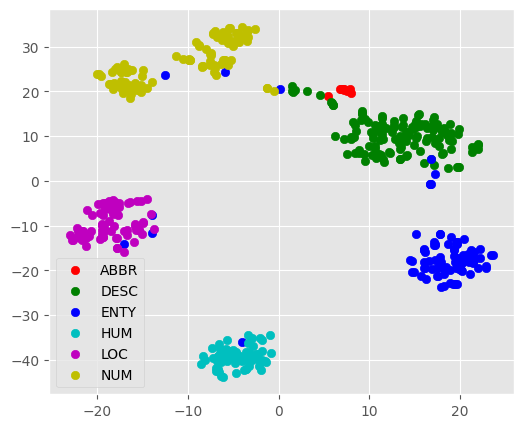


           Showing hiddent representation via PCA


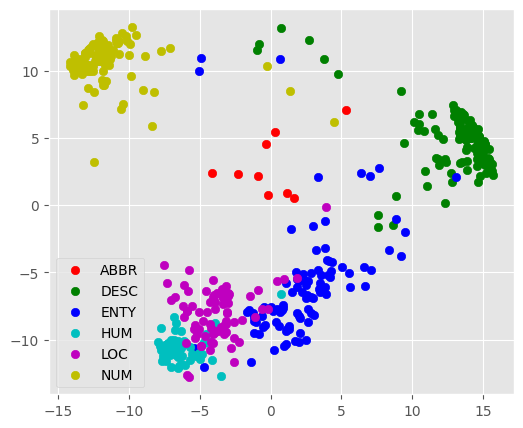

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

!pip install mpld3
%matplotlib inline
import mpld3
mpld3.enable_notebook()

def show_hidden_vectors(dataloader, classifier, label_list, mode="TSNE"):
  x = []
  y = []

  for batch in dataloader:
    # Unpack this training batch from our dataloader.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      _, cls_vectors = classifier(b_input_ids, b_input_mask)
      #hidden_states = model_outputs[-1]
      x.extend([t.detach().cpu().numpy() for t in cls_vectors])
      y.extend([t.detach().cpu().item() for t in b_labels])

  if mode == "TSNE":
    approx = TSNE(n_components=2, random_state=seed_val)
  else:
    approx = PCA(n_components=2, random_state=seed_val)

  X_2d = approx.fit_transform(np.asarray(x))
  y = np.asarray(y)

  target_ids = range(len(label_list))

  plt.figure(figsize=(6, 5))
  colors = "r", "g", "b", "c", "m", "y", "k", "w", "orange", "purple"
  for i, c, label in zip(target_ids, colors, label_list):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
  plt.legend()
  plt.show()

print("==================================================================")
print("           Showing hiddent representation via TSNE")
show_hidden_vectors(test_dataloader, best_model, label_list, mode = "TSNE")

print("\n==================================================================")
print("           Showing hiddent representation via PCA")
show_hidden_vectors(test_dataloader, best_model, label_list, mode = "PCA")